In [33]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

This code can work with tf.VERSION = '1.4.1' (for MacOS High Sierra); functions may change for other versions.

Model Parameters:

In [98]:
training_set_split = 0.8
validation_set_split = 0.1
learning_rate = np.logspace(-5,0,5)
num_units = 50 #number of units in RNN cell
training_steps = 40 #number of epochs
display_step = 20 #number of epochs after which to display progress
optimize_using = "adam" #other option: "momentum"

In [10]:
print("Tensorflow version: " + str(tf.VERSION))

Tensorflow version: 1.4.1


Loading JSON file into dictionary called 'student_vectors'

In [11]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

Collecting unique CCSSM labels and Task IDs

In [35]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


Creating 1-hot encoding for Task IDs and CCSSM Labels

In [36]:
#pre-processing for using MultiLabelBinarizer
temp_ids = []
for i in task_ids:
    temp_ids.append([i])

#generating encodings
enc = MultiLabelBinarizer()
task_ids_1hot = (enc.fit_transform(temp_ids)).astype(float)
task_ids_classes = enc.classes_
task_ids_dict = dict(zip(task_ids, task_ids_1hot))
# print("\n1-hot encoding for task IDs:")
# pp.pprint(task_ids_dict)

Generating input sequences of interactions to feed the network. Say we have 3 task IDs; here is an example of interaction vectors generated:
1. User correctly solves task 2 of label 3: [010   000]
2. User incorrectly solves task 1 of label 2: [000   100]

1-hot representation of task IDs: 
task ID 1: 1,0,0
task ID 2: 0,1,0
task ID 3: 0,0,1

In [49]:
sequences = []
output_y_taskid = []
output_y = []
seqlen = []
incorrect_tid_vec = np.zeros((len(task_ids)), dtype=np.float)
for i in student_vectors:
    temp_seq = []
    for j in student_vectors[i]:
        if(j['second_try'] == False): #ignoring second_try
            if(j['correct'] == True):
                vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                temp_seq.append(vec)
            else:
                vec = np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]])
                temp_seq.append(vec)
    seqlen.append(len(temp_seq))
    last_one = temp_seq.pop() #remove last interaction vector
    sequences.append(temp_seq) #add it to x
    first_one = temp_seq.pop(0) #remove first interaction vector
    temp_seq.append(last_one)
    output_y.append(temp_seq) #concatenate with last vector, and append to output!
    output_y_taskid.append(temp_seq)
    
# print("Sample interaction vector: ")
# pp.pprint(sequences[0][0])
length_interaction_vector = 2*(len(task_ids)) #length of interaction vector

Finding maximum sequence length.

In [50]:
max_seqlen = max(seqlen)
print("Maximum sequence length: "+str(max_seqlen))

Maximum sequence length: 186


Padding the sequences according to maximum sequence length. Making padded sequences of shape: number of students, maximum sequence length, length of interaction vector.

In [60]:
padded_sequences = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(sequences)):
    for j in range(len(sequences[i])):
        padded_sequences[i][j] = sequences[i][j]
print("Sequences have been padded according to the maximum sequence length. Final shape: " + str(padded_sequences.shape))

padded_output = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(output_y)):
    for j in range(len(output_y[i])):
        padded_output[i][j] = output_y[i][j]
        
padded_output_taskid = np.zeros(shape=(len(student_vectors),max_seqlen,length_interaction_vector),dtype=float)
for i in range(len(output_y_taskid)):
    for j in range(len(output_y_taskid[i])):
        padded_output_taskid[i][j] = output_y_taskid[i][j]

Sequences have been padded according to the maximum sequence length. Final shape: (1255, 186, 20)


Split the data into training and testing sets. Will take random validation sets at the time of training.<br>
Review: **Try using sklearn**

In [61]:
split = round((training_set_split+validation_set_split)*len(student_vectors))

#separating training & validation set
training_x = padded_sequences[:split]
training_y = np.asarray(padded_output)[:split]
training_y_taskid = np.asarray(padded_output_taskid)[:split]
training_seqlen = seqlen[:split]

#generating validation and training sets by implementing k-fold cross validation (k = maximum_position)
validation_set_size = math.floor(validation_set_split * len(student_vectors))
training_set_size = len(training_x) - validation_set_size
maximum_position = math.floor(len(training_x) / validation_set_size)

def get_next_train_valid_set(position):
    if(position>=maximum_position):
        position = position % maximum_position
    print("Picking validation set from position: "+str(position))
    valid_start = position*validation_set_size
    valid_end = valid_start + validation_set_size
    
    valid_set_x = training_x[valid_start : valid_end]
    valid_set_y = training_y[valid_start : valid_end]
    valid_set_y_taskid = np.asarray(training_y_taskid)[valid_start : valid_end]
    valid_set_seqlen = np.asarray(training_seqlen[valid_start:valid_end])
    
    train_set_x = np.concatenate((training_x[:valid_start], training_x[valid_end:]))
    train_set_y = np.concatenate((training_y[:valid_start], training_y[valid_end:]))
    train_set_y_taskid = np.concatenate((np.asarray(training_y_taskid)[:valid_start], np.asarray(training_y_taskid)[valid_end:]))
    train_set_seqlen = np.concatenate((np.asarray(training_seqlen)[:valid_start],np.asarray(training_seqlen)[valid_end:]))
    
    if(len(train_set_x) != training_set_size): #test
        print("that's not good it is:")
        print(train_set_x.shape)
    
    return (train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_taskid)

#separating test set
test_x = padded_sequences[split:]
test_y = np.asarray(padded_output)[split:]
test_y_taskid = np.asarray(padded_output_taskid)[split:]
test_seqlen = seqlen[split:]

print("Splitting "+str(len(student_vectors))+" rows into "+str(training_set_size)+ " for training, "+str(validation_set_size)+" for validation and "+str(len(test_x)) + " for testing.")
print("Implemented "+str(maximum_position)+"-fold cross validation.")

Splitting 1255 rows into 1005 for training, 125 for validation and 125 for testing.
Implemented 9-fold cross validation.


Building the model

In [108]:
tf.reset_default_graph()

#defining placeholders
x = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector]) #(<batch_size>, <max_time>, <num_features>)
y = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector]) #(<batch_size>, <num_features>)
y_taskid = tf.placeholder(tf.float32, [None, max_seqlen, length_interaction_vector])
seqlen_tf = tf.placeholder(tf.float32,[None])

#defining tensorflow variables
learning_tf_rate = tf.Variable(0.0, name="learning_tf_rate",dtype=tf.float32)

#dynamic RNN definition
def dynamicRNN(x):
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
    
    #transformation on outputs needed, otherwise auc=0
    #outputs = tf.transpose(outputs, [1, 0, 2])
    out_size = length_interaction_vector
    logit = tf.contrib.layers.fully_connected(outputs, out_size)
    outputs = tf.nn.sigmoid(logit)
    return outputs

#making predictions
pred = dynamicRNN(x)
    
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
if(optimize_using == "momentum"):
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_tf_rate,momentum=0.9).minimize(cost)
elif (optimize_using == "adagrad"):
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_tf_rate).minimize(cost)
elif (optimize_using == "adam"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_tf_rate).minimize(cost)
    

# Evaluate model - use AUC to evaluate model
auc,  opts = tf.metrics.auc(labels = y_taskid, predictions = pred, curve='ROC')

Training the model for hyperparameter (learning rate) tuning.

In [109]:
plot_lr = []
plot_valid_auc_taskid = []
plot_train_auc_taskid = []
with tf.Session() as sess:
    for l_r in learning_rate:
        plot_lr.append(l_r)    
        valid_taskid_list = []
        for k_fold in range(1,maximum_position+1):
            # Initialize the variables (i.e. assign their default value)
            print(str(k_fold)+"-fold cross-validation")
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            assign_op = learning_tf_rate.assign(l_r)
            sess.run(assign_op)
            print("Current Learning Rate: "+str(learning_tf_rate.eval()))
            train_set_seqlen,valid_set_seqlen,valid_set_x,valid_set_y,valid_set_y_taskid,train_set_x,train_set_y,train_set_y_taskid = get_next_train_valid_set(k_fold-1)
            for step in range(1, training_steps+1):
                batch_x = train_set_x
                batch_y = train_set_y
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})

                if step % display_step == 0 or step == 1:
                    loss,trainAUC,trainOPTS = sess.run([cost, auc, opts], feed_dict={x: batch_x, y: batch_y, y_taskid: train_set_y_taskid, seqlen_tf: train_set_seqlen})
                    #print status
                    print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()) + ", Train AUC:" + str(trainOPTS))
            #calculate validation AUC
            valid_auc_taskid, valid_opts_taskid = sess.run([auc, opts], feed_dict={x: valid_set_x, y: valid_set_y, y_taskid: valid_set_y_taskid, seqlen_tf: valid_set_seqlen})
            print("Valid_auc_taskid: " + str(valid_opts_taskid) + " with k = "+str(k_fold))
            valid_taskid_list.append(valid_opts_taskid)
            print("Optimization Finished!")
    
        #calculate training AUC (it should take both validation and training sets)
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})

        print("Train_auc_taskid: " + str(train_opts_taskid))
        plot_train_auc_taskid.append(train_opts_taskid)
        
        #take average of validation AUCs
        valid_avg_taskid = np.mean(valid_taskid_list)
        
        print("Average Valid_auc_taskid: " + str(valid_avg_taskid))
        plot_valid_auc_taskid.append(valid_avg_taskid)

1-fold cross-validation
Current Learning Rate: 1e-05
Picking validation set from position: 0
Step 1, Loss = 0.9667708, Learning Rate = 1e-05, Train AUC:0.7380419
Step 20, Loss = 0.9667416, Learning Rate = 1e-05, Train AUC:0.73790866
Step 40, Loss = 0.9667096, Learning Rate = 1e-05, Train AUC:0.7376664
Valid_auc_taskid: 0.73776305 with k = 1
Optimization Finished!
2-fold cross-validation
Current Learning Rate: 1e-05
Picking validation set from position: 1
Step 1, Loss = 0.9666594, Learning Rate = 1e-05, Train AUC:0.63231206
Step 20, Loss = 0.9666199, Learning Rate = 1e-05, Train AUC:0.63070047
Step 40, Loss = 0.966586, Learning Rate = 1e-05, Train AUC:0.62925243
Valid_auc_taskid: 0.6283644 with k = 2
Optimization Finished!
3-fold cross-validation
Current Learning Rate: 1e-05
Picking validation set from position: 2
Step 1, Loss = 0.9665316, Learning Rate = 1e-05, Train AUC:0.62026703
Step 20, Loss = 0.9665024, Learning Rate = 1e-05, Train AUC:0.6197806
Step 40, Loss = 0.96647424, Learnin

Step 1, Loss = 0.96632236, Learning Rate = 0.0031622776, Train AUC:0.6269261
Step 20, Loss = 0.96559155, Learning Rate = 0.0031622776, Train AUC:0.56347305
Step 40, Loss = 0.96559155, Learning Rate = 0.0031622776, Train AUC:0.54230756
Valid_auc_taskid: 0.54067075 with k = 4
Optimization Finished!
5-fold cross-validation
Current Learning Rate: 0.0031622776
Picking validation set from position: 4
Step 1, Loss = 0.9662424, Learning Rate = 0.0031622776, Train AUC:0.63925016
Step 20, Loss = 0.96561134, Learning Rate = 0.0031622776, Train AUC:0.5751304
Step 40, Loss = 0.96560794, Learning Rate = 0.0031622776, Train AUC:0.5542335
Valid_auc_taskid: 0.5525202 with k = 5
Optimization Finished!
6-fold cross-validation
Current Learning Rate: 0.0031622776
Picking validation set from position: 5
Step 1, Loss = 0.96640074, Learning Rate = 0.0031622776, Train AUC:0.5544811
Step 20, Loss = 0.9656537, Learning Rate = 0.0031622776, Train AUC:0.5333892
Step 40, Loss = 0.9656536, Learning Rate = 0.00316227

Step 40, Loss = 0.96553415, Learning Rate = 1.0, Train AUC:0.5
Valid_auc_taskid: 0.5 with k = 7
Optimization Finished!
8-fold cross-validation
Current Learning Rate: 1.0
Picking validation set from position: 7
Step 1, Loss = 0.96618456, Learning Rate = 1.0, Train AUC:0.5026301
Step 20, Loss = 0.9655815, Learning Rate = 1.0, Train AUC:0.5013138
Step 40, Loss = 0.9655817, Learning Rate = 1.0, Train AUC:0.5008754
Valid_auc_taskid: 0.5008433 with k = 8
Optimization Finished!
9-fold cross-validation
Current Learning Rate: 1.0
Picking validation set from position: 8
Step 1, Loss = 0.96552414, Learning Rate = 1.0, Train AUC:0.5
Step 20, Loss = 0.96552414, Learning Rate = 1.0, Train AUC:0.5
Step 40, Loss = 0.96552414, Learning Rate = 1.0, Train AUC:0.5
Valid_auc_taskid: 0.5 with k = 9
Optimization Finished!
Train_auc_taskid: 0.5
Average Valid_auc_taskid: 0.5109031


Plotting validation set ccssm auc across different learning rates.

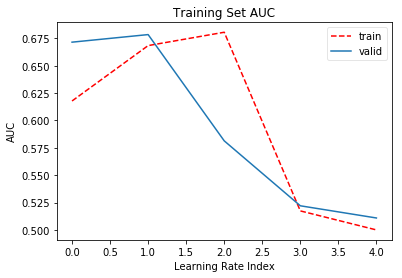

[1.00000000e-05 1.77827941e-04 3.16227766e-03 5.62341325e-02
 1.00000000e+00]


In [110]:
plt.title("Training Set AUC")
plt.xlabel("Learning Rate Index")
plt.ylabel("AUC")
plt.plot(plot_train_auc_taskid,'r--',label='train')
plt.plot(plot_valid_auc_taskid,label='valid')
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()
print(learning_rate)

#http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

Now Training the model with hyperparameters chosen from above and calculating testing AUC.

In [111]:
final_l_r = plot_lr[np.argmax(plot_valid_auc_taskid)]
with tf.Session() as sess:
    for l_r in [1.77827941e-04]:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        for step in range(1, training_steps*2+1):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
            
            if step % display_step == 0 or step == 1:
                loss= sess.run([cost], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                #print status
                print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
        print("Optimization Finished!")
    
        #calculate training AUC
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
        print("Train_auc_taskid: " + str(train_opts_taskid))
        
    # Calculate test auc
    temp_auc_taskid, temp_opts_taskid = sess.run([auc, opts], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid,seqlen_tf: test_seqlen})
    print("Testing auc for taskid: " + str(temp_opts_taskid))

Final Learning Rate: 0.00017782794
Step 1, Loss = [0.9665413], Learning Rate = 0.00017782794
Step 20, Loss = [0.9660948], Learning Rate = 0.00017782794
Step 40, Loss = [0.9657899], Learning Rate = 0.00017782794
Step 60, Loss = [0.965599], Learning Rate = 0.00017782794
Step 80, Loss = [0.96548843], Learning Rate = 0.00017782794
Optimization Finished!
Train_auc_taskid: 0.6155131
Testing auc for taskid: 0.6163878


In [112]:
final_l_r = plot_lr[np.argmax(plot_valid_auc_taskid)]
with tf.Session() as sess:
    for l_r in [1.77827941e-04]:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        for step in range(1, training_steps*2+1):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
            
            if step % display_step == 0 or step == 1:
                loss= sess.run([cost], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                #print status
                print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
        print("Optimization Finished!")
    
        #calculate training AUC
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
        print("Train_auc_taskid: " + str(train_opts_taskid))
        
    # Calculate test auc
    temp_auc_taskid, temp_opts_taskid = sess.run([auc, opts], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid,seqlen_tf: test_seqlen})
    print("Testing auc for taskid: " + str(temp_opts_taskid))

Final Learning Rate: 0.00017782794
Step 1, Loss = [0.9662086], Learning Rate = 0.00017782794
Step 20, Loss = [0.96580964], Learning Rate = 0.00017782794
Step 40, Loss = [0.96557605], Learning Rate = 0.00017782794
Step 60, Loss = [0.96547127], Learning Rate = 0.00017782794
Step 80, Loss = [0.9654327], Learning Rate = 0.00017782794
Optimization Finished!
Train_auc_taskid: 0.6355657
Testing auc for taskid: 0.6331784


In [113]:
final_l_r = plot_lr[np.argmax(plot_valid_auc_taskid)]
with tf.Session() as sess:
    for l_r in [3.16227766e-03]:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        for step in range(1, training_steps*2+1):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
            
            if step % display_step == 0 or step == 1:
                loss= sess.run([cost], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                #print status
                print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
        print("Optimization Finished!")
    
        #calculate training AUC
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
        print("Train_auc_taskid: " + str(train_opts_taskid))
        
    # Calculate test auc
    temp_auc_taskid, temp_opts_taskid = sess.run([auc, opts], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid,seqlen_tf: test_seqlen})
    print("Testing auc for taskid: " + str(temp_opts_taskid))

Final Learning Rate: 0.0031622776
Step 1, Loss = [0.965967], Learning Rate = 0.0031622776
Step 20, Loss = [0.9654031], Learning Rate = 0.0031622776
Step 40, Loss = [0.9653683], Learning Rate = 0.0031622776
Step 60, Loss = [0.96532255], Learning Rate = 0.0031622776
Step 80, Loss = [0.96525156], Learning Rate = 0.0031622776
Optimization Finished!
Train_auc_taskid: 0.6022035
Testing auc for taskid: 0.6028356


In [118]:
final_l_r = plot_lr[np.argmax(plot_valid_auc_taskid)]
with tf.Session() as sess:
    for l_r in [0.00001]:
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        assign_op = learning_tf_rate.assign(l_r)
        sess.run(assign_op)
        print("Final Learning Rate: "+str(learning_tf_rate.eval()))
        for step in range(1, training_steps*2+1):
            sess.run(optimizer, feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
            
            if step % display_step == 0 or step == 1:
                loss= sess.run([cost], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
                #print status
                print("Step " + str(step) + ", Loss = " + str(loss) + ", Learning Rate = "+str(learning_tf_rate.eval()))
        print("Optimization Finished!")
    
        #calculate training AUC
        train_auc_taskid, train_opts_taskid = sess.run([auc, opts], feed_dict={x: training_x, y: training_y, y_taskid: training_y_taskid, seqlen_tf: training_seqlen})
        print("Train_auc_taskid: " + str(train_opts_taskid))
        
    # Calculate test auc
    temp_auc_taskid, temp_opts_taskid = sess.run([auc, opts], feed_dict={x: test_x, y: test_y, y_taskid: test_y_taskid,seqlen_tf: test_seqlen})
    print("Testing auc for taskid: " + str(temp_opts_taskid))

Final Learning Rate: 1e-05
Step 1, Loss = [0.96649164], Learning Rate = 1e-05
Step 20, Loss = [0.966464], Learning Rate = 1e-05
Step 40, Loss = [0.966427], Learning Rate = 1e-05
Step 60, Loss = [0.96639806], Learning Rate = 1e-05
Step 80, Loss = [0.96637046], Learning Rate = 1e-05
Optimization Finished!
Train_auc_taskid: 0.6767011
Testing auc for taskid: 0.68035626


<Container object of 10 artists>

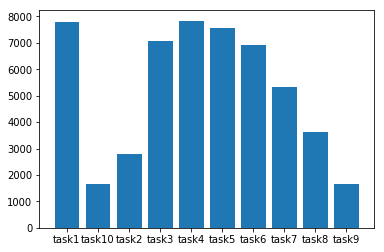

In [105]:
from collections import Counter
#frequency distribution of taskids
cnt = Counter()
cnt2 = Counter()
another = {}
position = 1
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['ccssm'] not in another:
            another[j['ccssm']] = "label" + str(position)
            position = position + 1
        cnt[another[j['ccssm']]] += 1
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = "task" + str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())

<Container object of 4 artists>

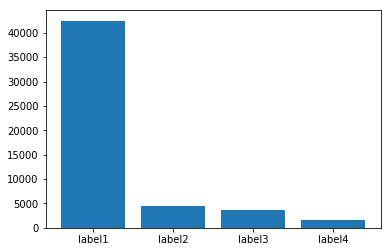

In [82]:
plt.bar(cnt.keys(), cnt.values())